In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE
from sklearn.manifold import MDS


from sklearn import preprocessing

In [3]:
df = pd.read_csv('titanic.csv')

# Знакомство с датасетом

In [4]:
df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

# Предварительная обработка

In [7]:
# Удаляем ненужные столбцы
df = df.drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis=1)

In [8]:
# Кодируем поле Пол
df.loc[df['Sex'] == 'male', 'Sex'] = 1
df.loc[df['Sex'] == 'female', 'Sex'] = 0
df.Sex = df.Sex.astype(bool)

In [9]:
# Кодируем поле Embarked
le = preprocessing.LabelEncoder()
le.fit(df['Embarked'])
df['Embarked'] = le.transform(df['Embarked'])
df

Survived  Pclass    Sex   Age  SibSp  Parch     Fare  Embarked
0           0       3   True  22.0      1      0   7.2500         2
1           1       1  False  38.0      1      0  71.2833         0
2           1       3  False  26.0      0      0   7.9250         2
3           1       1  False  35.0      1      0  53.1000         2
4           0       3   True  35.0      0      0   8.0500         2
..        ...     ...    ...   ...    ...    ...      ...       ...
886         0       2   True  27.0      0      0  13.0000         2
887         1       1  False  19.0      0      0  30.0000         2
888         0       3  False   NaN      1      2  23.4500         2
889         1       1   True  26.0      0      0  30.0000         0
890         0       3   True  32.0      0      0   7.7500         1

[891 rows x 8 columns]

In [10]:
# Заполняем возраст медианой
df.Age.fillna(df.Age.median(), inplace = True)

In [11]:
df

Survived  Pclass    Sex   Age  SibSp  Parch     Fare  Embarked
0           0       3   True  22.0      1      0   7.2500         2
1           1       1  False  38.0      1      0  71.2833         0
2           1       3  False  26.0      0      0   7.9250         2
3           1       1  False  35.0      1      0  53.1000         2
4           0       3   True  35.0      0      0   8.0500         2
..        ...     ...    ...   ...    ...    ...      ...       ...
886         0       2   True  27.0      0      0  13.0000         2
887         1       1  False  19.0      0      0  30.0000         2
888         0       3  False  28.0      1      2  23.4500         2
889         1       1   True  26.0      0      0  30.0000         0
890         0       3   True  32.0      0      0   7.7500         1

[891 rows x 8 columns]

# Визуализация датасета

In [12]:
tsne = TSNE(n_components=2, 
             init="pca", 
             random_state=0,
             perplexity=50,
             n_iter = 1000,
             metric = 'cosine')

In [13]:
Y = tsne.fit_transform(df.iloc[:,1:])

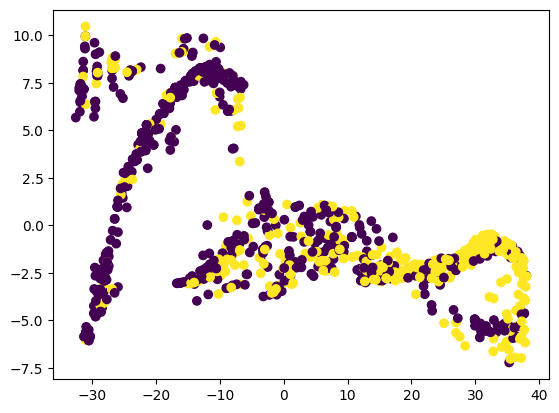

In [14]:
plt.scatter(Y[:,0], Y[:,1], c = df.iloc[:,0])

In [15]:
mds = MDS(n_components=2, 
             random_state=0)

In [16]:
Y_MDS = mds.fit_transform(df.iloc[:,1:])

C:\Users\Андрей\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


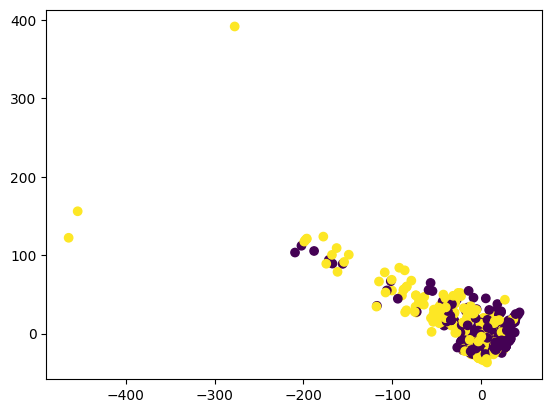

In [17]:
plt.scatter(Y_MDS[:,0], Y_MDS[:,1], c = df.iloc[:,0])


## Графики по столбцам

<Axes: xlabel='Survived', ylabel='count'>

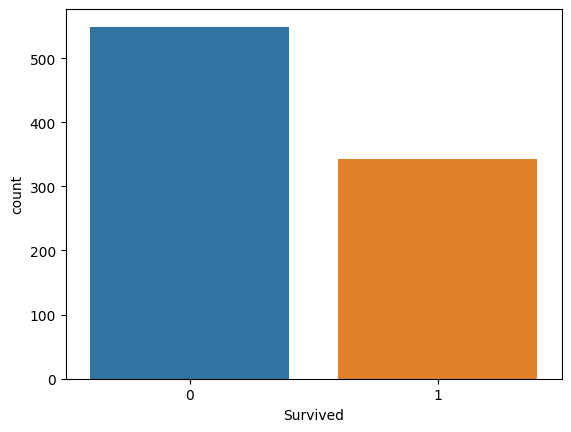

In [18]:
sns.countplot(x = df.Survived)

<Axes: xlabel='Pclass', ylabel='count'>

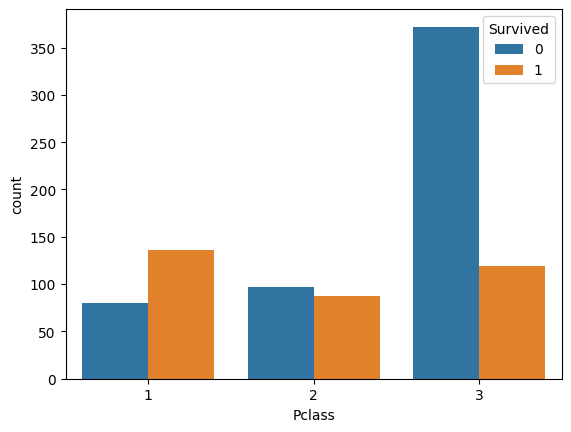

In [19]:
sns.countplot(x = df.Pclass, hue = df.Survived)

<Axes: xlabel='Fare', ylabel='Count'>

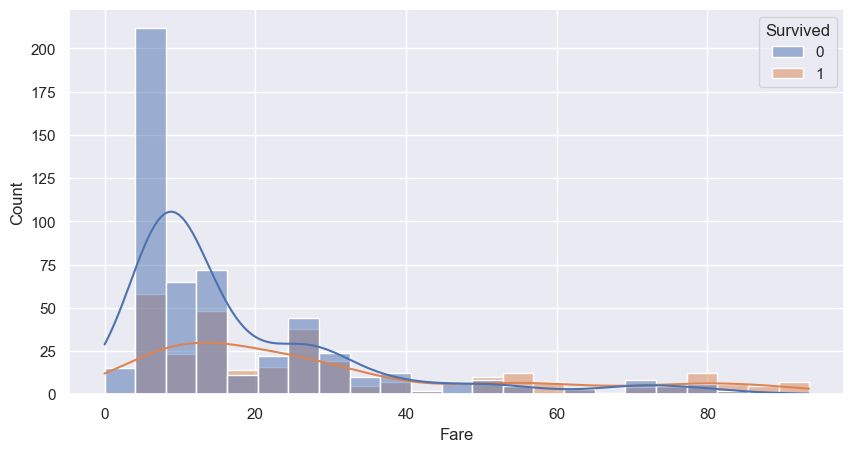

In [20]:
sns.set(rc={'figure.figsize':(10,5)})
sns.histplot(x = df.loc[df.Fare < 100].Fare, hue  = df.Survived, kde=True,  )


<Axes: xlabel='Age', ylabel='Count'>

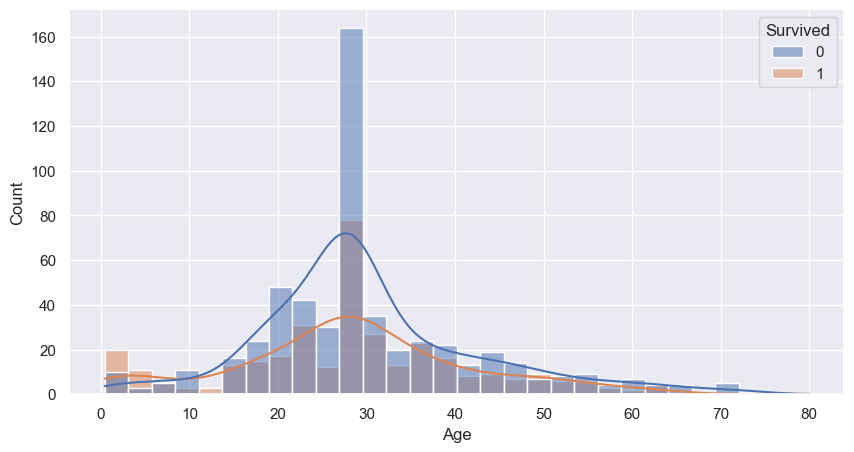

In [21]:
sns.set(rc={'figure.figsize':(10,5)})
sns.histplot(x = df.Age, hue  = df.Survived, kde=True )


<Axes: xlabel='SibSp', ylabel='Count'>

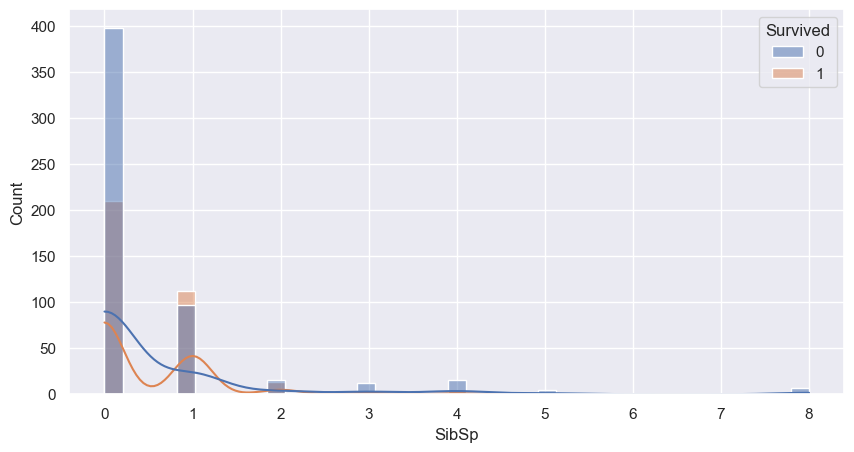

In [22]:
sns.set(rc={'figure.figsize':(10,5)})
sns.histplot(x = df.SibSp, hue  = df.Survived, kde=True )


## Корреляционная матрица

<Axes: >

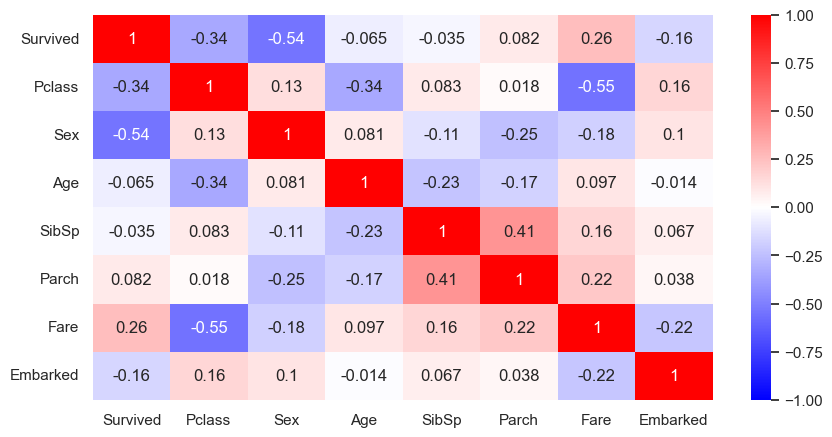

In [23]:
sns.heatmap(df.corr(numeric_only = True), annot = True,  vmin=-1, vmax=1, cmap = 'bwr')

# Классификация

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size=0.33, random_state=42) 

In [25]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
rf_prediction = RF.predict(X_test)

In [26]:
print('Conf matrix')
print(metrics.confusion_matrix(rf_prediction, y_test))
print('Classification report')
print(metrics.classification_report(rf_prediction, y_test))

Conf matrix
[[143  33]
 [ 32  87]]
Classification report
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       176
           1       0.72      0.73      0.73       119

    accuracy                           0.78       295
   macro avg       0.77      0.77      0.77       295
weighted avg       0.78      0.78      0.78       295



In [27]:
# Вероятности каждого класса
rf_prediction_proba = RF.predict_proba(X_test)
rf_prediction_proba

array([[0.66      , 0.34      ],
       [0.965     , 0.035     ],
       [0.83833333, 0.16166667],
       [0.02      , 0.98      ],
       [0.76      , 0.24      ],
       [0.06      , 0.94      ],
       [0.13648918, 0.86351082],
       [0.89      , 0.11      ],
       [0.25266667, 0.74733333],
       [0.03      , 0.97      ],
       [0.56      , 0.44      ],
       [0.935     , 0.065     ],
       [0.94      , 0.06      ],
       [0.92      , 0.08      ],
       [0.679     , 0.321     ],
       [0.05      , 0.95      ],
       [0.67      , 0.33      ],
       [0.14376299, 0.85623701],
       [0.81      , 0.19      ],
       [0.96      , 0.04      ],
       [0.99      , 0.01      ],
       [0.43666667, 0.56333333],
       [0.88      , 0.12      ],
       [1.        , 0.        ],
       [0.99      , 0.01      ],
       [0.91      , 0.09      ],
       [0.68      , 0.32      ],
       [0.901     , 0.099     ],
       [0.78      , 0.22      ],
       [0.38      , 0.62      ],
       [1.

In [28]:
rf_prediction

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0], dtype=int64)

## Важность признаков

In [30]:
fi = pd.DataFrame(RF.feature_importances_, RF.feature_names_in_)
fi

0
Pclass    0.087579
Sex       0.249358
Age       0.255040
SibSp     0.051566
Parch     0.040596
Fare      0.275444
Embarked  0.040416

<Axes: >

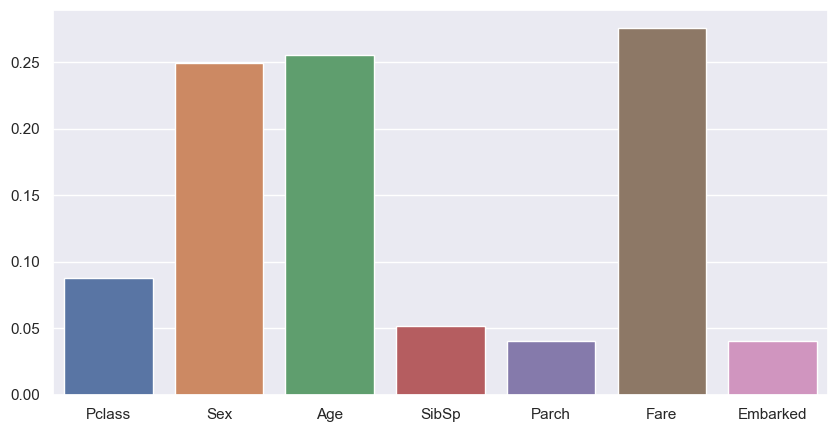

In [31]:
 sns.barplot(fi.T)

In [32]:
X_train_sef = X_train[['Sex', 'Age', 'Fare']]
X_test_sef = X_test[['Sex', 'Age', 'Fare']]
RF_sef = RandomForestClassifier()
RF_sef.fit(X_train_sef, y_train)
rf_sef_prediction =RF_sef.predict(X_test_sef )

In [33]:
print('Conf matrix')
metrics.confusion_matrix(rf_sef_prediction, y_test)
print('Classification report')
print(metrics.classification_report(rf_sef_prediction, y_test))

Conf matrix
Classification report
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       184
           1       0.69      0.75      0.72       111

    accuracy                           0.78       295
   macro avg       0.77      0.77      0.77       295
weighted avg       0.78      0.78      0.78       295



## XGBoost

In [34]:
from xgboost import XGBClassifier

In [35]:

XGB = XGBClassifier()
XGB.fit(X_train, y_train)
xgb_prediction =XGB.predict(X_test )
print('Conf matrix')
print(metrics.confusion_matrix(xgb_prediction, y_test))
print('Classification report')
print(metrics.classification_report(xgb_prediction, y_test))

Conf matrix
[[141  31]
 [ 34  89]]
Classification report
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       172
           1       0.74      0.72      0.73       123

    accuracy                           0.78       295
   macro avg       0.77      0.77      0.77       295
weighted avg       0.78      0.78      0.78       295



In [36]:

XGB_sef = XGBClassifier()
XGB_sef.fit(X_train_sef, y_train)
xgb_sef_prediction =XGB_sef.predict(X_test_sef)
print('Conf matrix')
print(metrics.confusion_matrix(xgb_sef_prediction, y_test))
print('Classification report')
print(metrics.classification_report(xgb_sef_prediction, y_test))

Conf matrix
[[150  37]
 [ 25  83]]
Classification report
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       187
           1       0.69      0.77      0.73       108

    accuracy                           0.79       295
   macro avg       0.77      0.79      0.78       295
weighted avg       0.80      0.79      0.79       295



<Axes: >

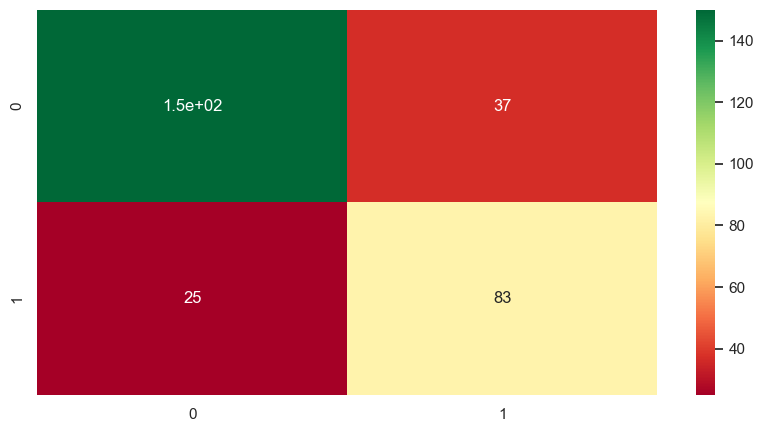

In [37]:
sns.heatmap(metrics.confusion_matrix(xgb_sef_prediction, y_test), annot = True, cmap = 'RdYlGn')

## Попробуем настроить параметры для RF

In [45]:
X_train_sef = X_train[['Sex', 'Age', 'Fare']]
X_test_sef = X_test[['Sex', 'Age', 'Fare']]

params = {
    'n_estimators': [1, 10, 50, 100],
    'max_depth': [1, 5, 10],
    'criterion':['gini', 'entropy']
}


RF_sef_gs = RandomForestClassifier()

gs = GridSearchCV(param_grid=params, estimator=RF_sef_gs)
gs.fit(X_train_sef, y_train)
rf_sef_gs_prediction=gs.predict(X_test_sef )


In [46]:
gs.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50}

In [47]:
print('Conf matrix')
print(metrics.confusion_matrix(rf_sef_gs_prediction, y_test))
print('Classification report')
print(metrics.classification_report(rf_sef_gs_prediction, y_test))

Conf matrix
[[154  34]
 [ 21  86]]
Classification report
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       188
           1       0.72      0.80      0.76       107

    accuracy                           0.81       295
   macro avg       0.80      0.81      0.80       295
weighted avg       0.82      0.81      0.82       295

